In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import genjax
from genjax import gen, choice_map, vector_choice_map
import jax
from jax import jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import trimesh
from bayes3d._mkl.utils import *
from bayes3d._mkl.importance import _importance_sampling


key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

In [4]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose
from bayes3d._mkl.meshes import *
from bayes3d._mkl.plotting import *

fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts  = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T      = len(_xs)
_segs   = _segs.reshape(-1,2,2)
_boxes  = _boxes.reshape(-1,2,2)
_bb     = bounding_box(_segs)
_ps     = np.concatenate([_xs, _hds[:,None]], axis=1)

_T

50

In [6]:
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs.reshape(-1,4))
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)
map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2]    -= 0.5

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)
['object_0', 'object_1']


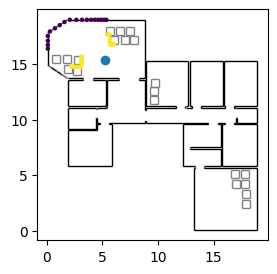

In [18]:
w = 50
h = 1

near = .01
far  = 10.0

fx = 10
fy = 10

cx = w/2 - 0.5
cy = h/2 - 0.5

intrinsics = b3d.Intrinsics(
    height = h,
    width  = w,
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    near=near, far=far
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p, inds=[0,1]):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps[t]
X = render(lift_pose(p[:2], p[2]), inds=[0,1])
xs = X[0][:,[0,2]]
xs = apply_2dpose(p, xs)

# -----------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(plt.gca(),_segs, c="k", zorder=-1)
plot_segs(plt.gca(),_boxes, c="gray", zorder=-1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=X[0,:,3], vmin=1, vmax=2, s=5)

## Making the model

In [25]:
from genjax import tfp_uniform as uniform
from bayes3d._mkl.likelihood import (
    make_point_cloud_baseline_model,
    make_constrained_baseline_model,
    make_truncated_constrained_baseline_model,
)

def make_model(w:int, zmax:float, model_type:str):

    # TODO: Note that we shouldn't have to do this! 
    # There is an underlying bug. Ask McCoy if the issue got resolved yet.
    
    if model_type == "point-cloud":
        sensor_model = make_point_cloud_baseline_model(w, zmax)
    elif model_type == "constrained":
        sensor_model = make_constrained_baseline_model(w, zmax)
    elif model_type == "constrained-truncated":
        sensor_model = make_truncated_constrained_baseline_model(w, zmax)
    else:
        raise f"Model type not defined {model_type}"
    
    @gen
    def model(inds):

        x  = uniform(jnp.array([-20.,-20.]), 
                     jnp.array([ 20., 20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi)        @ "hd"
        
        # Sample Hyper Parameters
        sig     = uniform(0.0, 1.) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        # Lift pose to 3D and 
        # render an image
        Y = render(lift_pose(x, hd), inds)
        # Sample X conditioned on Y
        X = sensor_model.inline(Y[:,:,:3], sig, outlier) # @ Address "X"

        return pack_2dpose(x, hd), X[0][:,[0,2]]
    
    return model


In [26]:
def plot_tr(tr, ax=None, title=""):
    
    if ax is None:
        plt.figure(figsize=(5,5))
        ax=plt.gca()

    p, xs = tr.get_retval()


    # ---------------------
    if len(title) > 0: title = f"{title}\n"
    ax.set_title(f"{title}score = {tr.get_score():0.2f}")
    ax.set_aspect(1)
    PAD = 4
    ax.set_xlim(*bounding_box(_segs, pad=PAD)[:,0])
    ax.set_ylim(*bounding_box(_segs, pad=PAD)[:,1])
    plot_segs(ax, _segs, c="k", zorder=1)
    plot_segs(ax, _boxes, c="k", zorder=1)
    ax.scatter(*p[:2], c="r", zorder=2)
    ax.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)

In [27]:
def get_data_logprobs(tr):
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps


def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch = choice_map({
        'x':  p[:2], 
        'hd': p[ 2],
        'sig':     sig,
        'outlier': outlier,
        })
    diffs = argdiffs(tr.args)
    (_, w, tr_, _) = tr.update(key, ch, diffs)
    log_ps = get_data_logprobs(tr_)
    return tr_.get_score(), log_ps

eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))

## Perturbing the Trace

In [28]:
@genjax.gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd)             @ "hd"
    
    return pack_2dpose(x, adjust_angle(hd))

In [30]:
# Get true pose and observations
t0 = 40
p0 = _ps[t0]

X0  = render(lift_pose(p0[:2], p0[2]), inds=[0,1])
X0  = X0[:,:,:3].reshape(-1,3)
D0 = jnp.linalg.norm(X0, axis=-1)
xs = X0[:,[0,2]]
X0.shape, xs.shape, D0.shape

((50, 3), (50, 2), (50,))

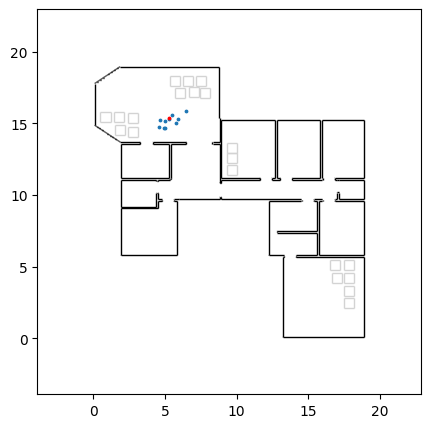

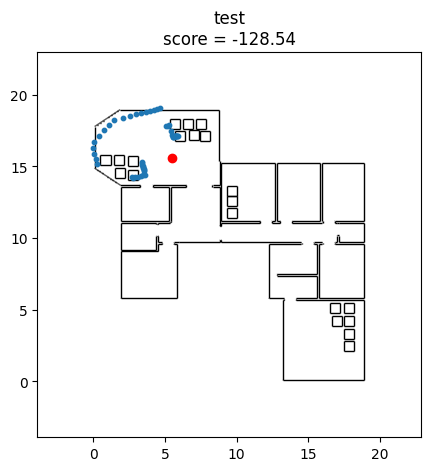

In [31]:
w     = 5
zmax  = 10.
model_type = "constrained" 


obs = genjax.choice_map({"X": 
        genjax.vector_choice_map({
            "measurement":  D0 if "constrained" in model_type else X0
        }) 
})


model = make_model(w, zmax, model_type)
N     = 10
key   = keysplit(key)
(trs, ws, _) = _importance_sampling(key,
                                    model, (jnp.array([0]),), obs,  
                                    anchored_pose_prior, (p0, .5, 15), 
                                    N=N)


# -----------------------
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_aspect(1)
PAD = 4; zoom_in(ax, _bb, PAD);
plot_segs(ax, _segs, c="k", zorder=1)
plot_segs(ax, _boxes, c="lightgray", zorder=1)
ax.scatter(*trs['x'].T, s=3, c="C0")
ax.scatter(*p0[:2], s=3, c="r")

i = jnp.argmax(ws)
plot_tr(trs.slice(i), None, title="test")

## The Grid

In [33]:
def get_linear_grid(shape, args):
    n = len(shape)
    vs = jnp.stack(jnp.meshgrid(
        *[jnp.linspace(*a, d) for a,d in zip(args, shape)],
    indexing='ij'), axis=-1)

    return vs


def make_inference_grid(tr, shape, dx, dhd, sig=(0.01, 0.5), outlier=(0.001, 0.5)):
    args  = (
        (tr['x'][0]-dx,tr['x'][0]+dx),
        (tr['x'][1]-dx,tr['x'][1]+dx),
        (tr['hd']-dhd,tr['hd']+dhd),
        sig,
        outlier,
    )
    return get_linear_grid(shape, args)


In [34]:
def plot_pose_grid(ax, vs, sc, p0, xs, logps, *, PAD=4, quantile=0.5):
    sc = sc.reshape(-1)
    vs = vs.reshape(-1, vs.shape[-1])
    logps = logps.reshape(-1, logps.shape[-1])
    order = jnp.argsort(sc)

    sc    = sc[order]
    vs    = vs[order]
    logps = logps[order]
    
    mask = sc > -jnp.inf
    sc = sc[mask]
    vs = vs[mask] 
    sc  = jnp.clip(sc, -1e6,  jnp.max(sc))
    sc  = jnp.clip(sc, jnp.quantile(sc, quantile), jnp.max(sc))
    cs  = plt.cm.viridis(plt.Normalize()(sc))

    a = vs[:,:2]
    b = a + 0.3*jax.vmap(unit_vec)(vs[:,2])

    # ---------------------
    ax.set_aspect(1)
    zoom_in(ax, jnp.mean(vs, axis=0)[:2], PAD)
    plot_segs(ax,  _segs, c="k", zorder=2)
    plot_segs(ax, _boxes, c="lightgray", zorder=2)
    ax.scatter(*apply_2dpose(vs[-1,:3], xs).T, s=30, c=logps[-1], alpha=1., zorder=3, )
    ax.plot(*jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
            c="r", zorder=4, linewidth=2)
    ax.add_collection(line_collection(a,b, c=cs, zorder=1, linewidth=2));

## Experiment

In [40]:
# Get true pose and observations
t0 = 40
p0 = _ps[t0]

X0 = render(lift_pose(p0[:2], p0[2]), inds=[0,1])
X0 = X0[:,:,:3].reshape(-1,3)
D0 = jnp.linalg.norm(X0, axis=-1)
xs = X0[:,[0,2]]

X0.shape, D0.shape

((50, 3), (50,))

In [41]:
w     = 5
zmax  = 4.
model_type = "constrained" 

obs = genjax.choice_map({"X": 
        genjax.vector_choice_map({
            "measurement":  D0 if "constrained" in model_type else X0
        }) 
})

model = make_model(w, zmax, model_type)
N     = 10
key = keysplit(key)
(trs, ws, _) = _importance_sampling(key,
                                    model, (jnp.array([0]),), obs,  
                                    anchored_pose_prior, (p0, .5, 15), 
                                    N=N)

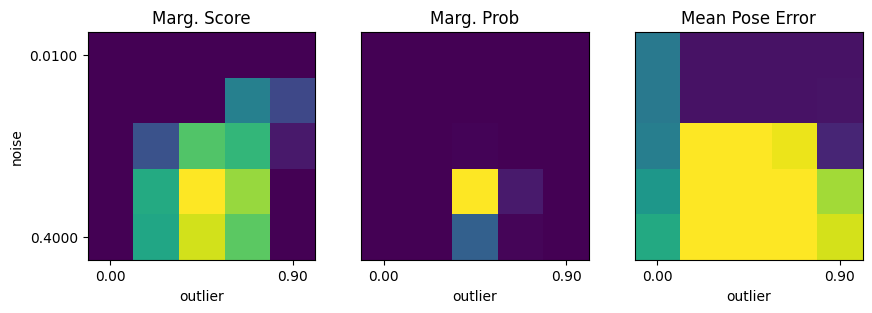

In [47]:
i = 1
tr = trs.slice(i)

dx  = 1.
dhd = 35/180*jnp.pi
shape = (5,5,5, 5,5)

# Grid
vs = make_inference_grid(tr, shape, 
                dx, dhd,  
                sig     = (0.01, 0.4), 
                outlier = (0.00, 0.9))
vs_flat = vs.reshape(-1, len(shape))

# Error: Grid -vs- True
x_diff   = vs_flat[:,:2]-p0[:2]
hd_diff  = jax.vmap(adjust_angle)(vs_flat[:,2]-p0[2])
diff     = jnp.concatenate([x_diff,hd_diff[:,None]], axis=-1)
err_flat = jnp.linalg.norm(diff, axis=-1)
err      = err_flat.reshape(shape)

# Eval Grid
key = keysplit(key)
sc_flat, logps = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4])
sc    = sc_flat.reshape(shape)
logps = logps.reshape(shape + (50,))

# Marginalize out poses (2d pos and rot)
sc_marg  = logsumexp(sc, axis=(0,1,2))
sc_marg  = sc_marg - logsumexp(sc_marg)
sc_marg_ = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.5), jnp.max(sc_marg))

# Mean Pose error
pr       = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
mean_err = jnp.sum(pr*err, axis=(0,1,2))

# -----------------------------------------
fig, axs = plt.subplots(1,3,figsize=(10,4), sharex=True)

axs[0].set_title("Marg. Score")
axs[0].imshow(sc_marg_)
axs[0].set_xticklabels(vs[0,0,0,0,:1,4])
axs[0].set(
    xlabel="outlier",
    xticks=[0, shape[4]-1], 
    xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
    ylabel="noise",
    yticks=[0, shape[3]-1], 
    yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
)

axs[1].set_title("Marg. Prob")
axs[1].imshow(jnp.exp(sc_marg), vmin=0.0)
axs[1].set(
    xlabel="outlier",
    xticks=[0, shape[4]-1], 
    xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
    yticks=[],
)

axs[2].set_title("Mean Pose Error")
axs[2].imshow(mean_err, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis")
axs[2].set(
    xlabel="outlier",
    xticks=[0, shape[4]-1], 
    xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
    yticks=[],
);

In [48]:
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider

@interact(
        i = IntSlider(min=0, max=N-1, step=1, value=0, continuous_update=False),
        num_x    = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_hd   = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_sig = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_out = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        sig = FloatRangeSlider(min=1e-6, max=1.0, step=0.01, value=[0.01,0.5], continuous_update=False),
        out = FloatRangeSlider(min=0, max=1.0, step=0.01, value=[0.0,0.9], continuous_update=False),
)
def func(i, num_x,num_hd,num_sig,num_out, sig, out):
        
        global key;
        
        tr = trs.slice(i)

        dx  = 1.
        dhd = 35/180*jnp.pi
        shape = (num_x, num_x, num_hd, num_sig, num_out)

        # Grid
        vs = make_inference_grid(tr, shape, 
                                 dx, dhd,  
                                 sig     = sig, 
                                 outlier = out)
        vs_flat = vs.reshape(-1, len(shape))

        # Error: Grid -vs- True
        x_diff   = vs_flat[:,:2]-p0[:2]
        hd_diff  = jax.vmap(adjust_angle)(vs_flat[:,2]-p0[2])
        diff     = jnp.concatenate([x_diff,hd_diff[:,None]], axis=-1)
        err_flat = jnp.linalg.norm(diff, axis=-1)
        err      = err_flat.reshape(shape)

        # Eval Grid
        key = keysplit(key)
        sc_flat, logps = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4])
        sc    = sc_flat.reshape(shape)
        logps = logps.reshape(shape + (50,))

        # Marginalize out poses (2d pos and rot)
        sc_marg  = logsumexp(sc, axis=(0,1,2))
        sc_marg  = sc_marg - logsumexp(sc_marg)
        sc_marg_ = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.5), jnp.max(sc_marg))

        # Mean Pose error
        pr       = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
        mean_err = jnp.sum(pr*err, axis=(0,1,2))


        # -----------------------------------------
        fig, axs = plt.subplots(1,3,figsize=(10,4), sharex=True)

        axs[0].set_title("Marg. Score")
        axs[0].imshow(sc_marg_)
        axs[0].set_xticklabels(vs[0,0,0,0,:1,4])
        axs[0].set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                ylabel="noise",
                yticks=[0, shape[3]-1], 
                yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
        );

        axs[1].set_title("Marg. Prob")
        axs[1].imshow(jnp.exp(sc_marg), vmin=0.0)
        axs[1].set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                yticks=[],
        );

        axs[2].set_title("Mean Pose Error")
        axs[2].imshow(mean_err, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis")
        axs[2].set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                yticks=[],
        );

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=9), IntSlider(value=5, …

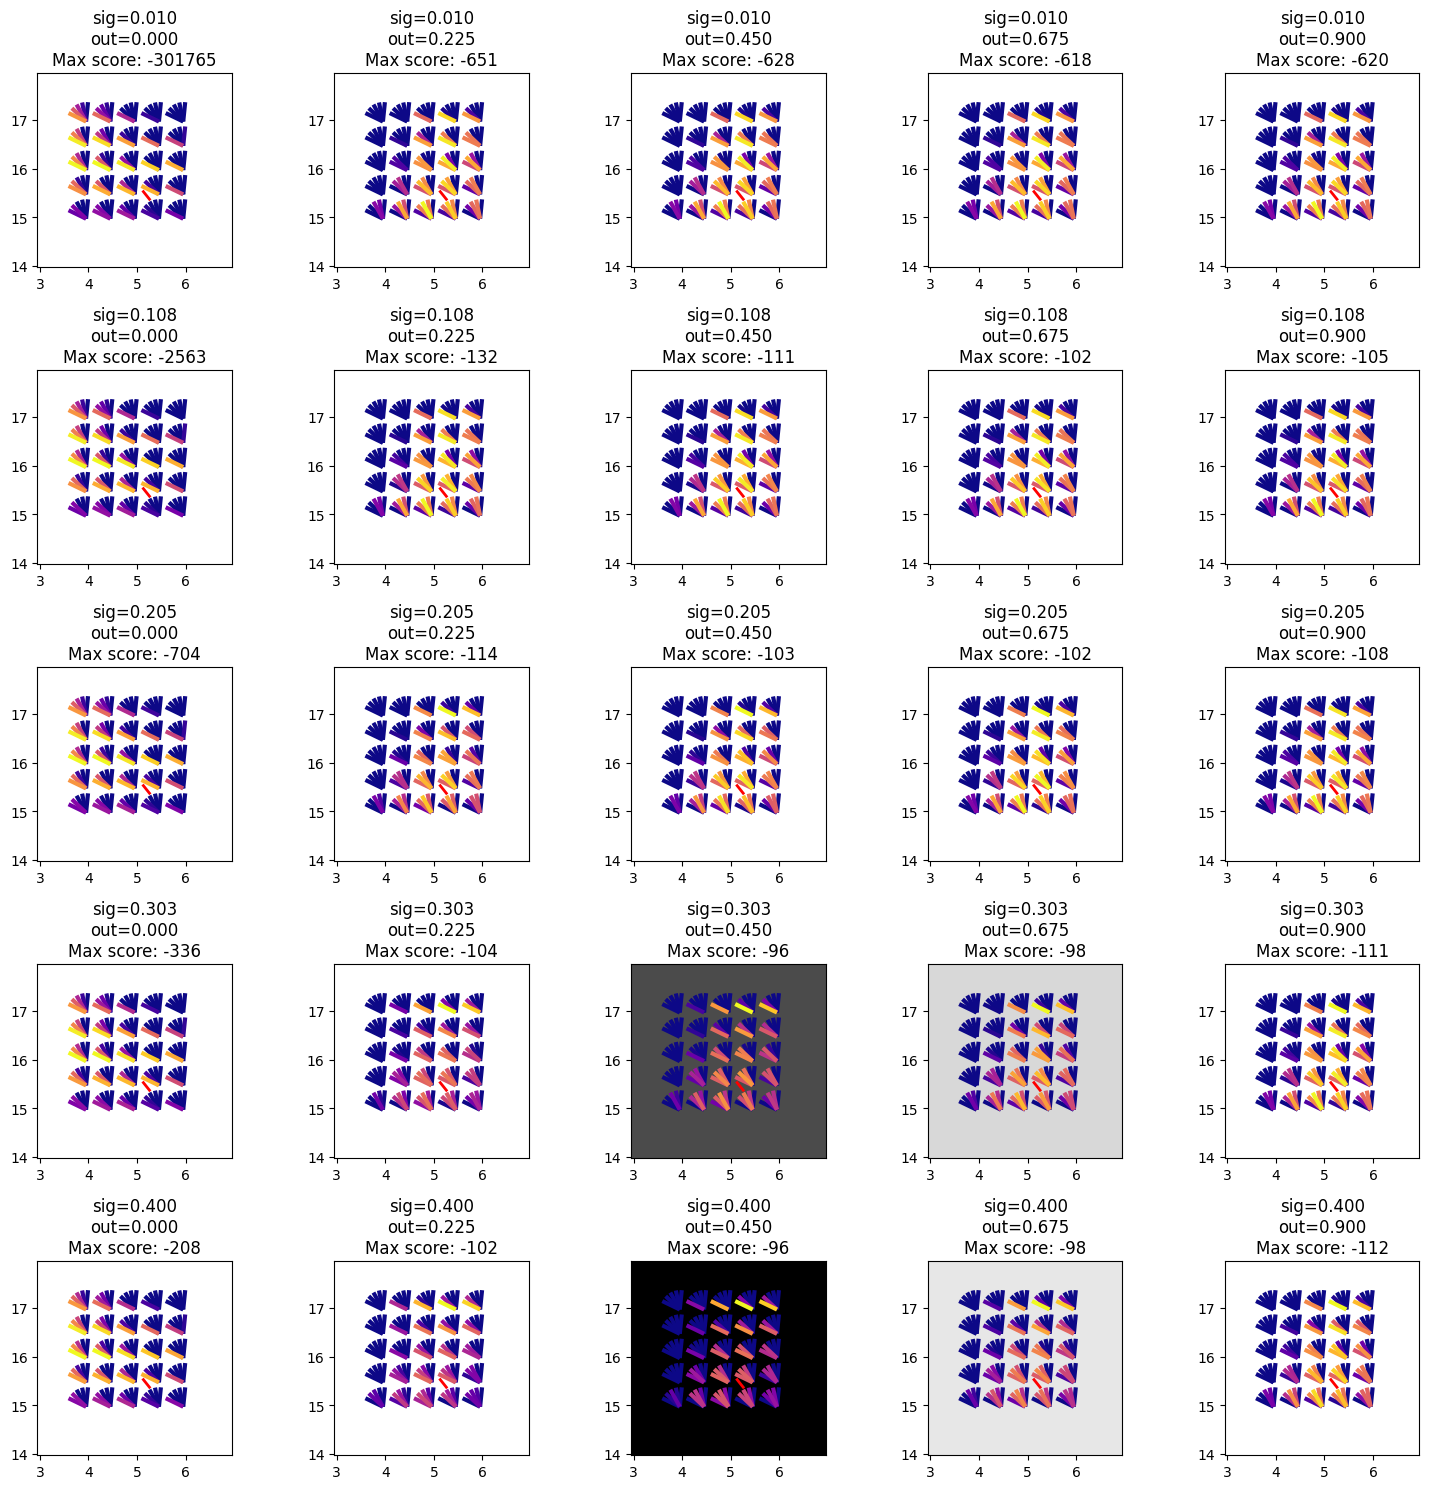

In [44]:
fig, axs = plt.subplots(*shape[3:], figsize=(15,15))



sc_marg = logsumexp(sc, axis=(0,1,2))
sc_marg = sc_marg - logsumexp(sc_marg)
sc_marg = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.5), jnp.max(sc_marg))
cs_marg  = plt.cm.binary(plt.Normalize()(jnp.exp(sc_marg)))


for i in range(shape[3]):
    for j in range(shape[4]):
        

        vs_ = vs[:,:,:,i,j].reshape(-1,5) 
        sc_ = sc[:,:,:,i,j].reshape(-1)

        order = jnp.argsort(sc_)
        sc_ = sc_[order]
        vs_ = vs_[order]
    

        # cs_ = cs[:,:,:,i,j].reshape(-1,4)
        # cs_ = cs_[order]

        # print(i,j, jnp.sum(sc_ == -jnp.inf ))

        sc__ = jnp.clip(sc_, -1e6,  jnp.max(sc_))
        sc__ = jnp.clip(sc__, jnp.quantile(sc__, 0.6), jnp.max(sc__))
        cs_  = plt.cm.plasma(plt.Normalize()(sc__))
    

        a = vs_[:,:2]
        b = a + 0.4 * jax.vmap(unit_vec)(vs_[:,2])

        seg_color = "k"

        # ---------------------
        ax = axs[i][j]
        ax.set_title(f"sig={vs_[0,3]:0.3f}\nout={vs_[0,4]:0.3f}\nMax score: {jnp.max(sc_):.0f}")
        ax.set_aspect(1)
        PAD = 2

        center = (vs[0,0,0,i,j,:2] + vs[-1,-1,0,i,j,:2])/2
        zoom_in(ax, center, PAD)
        # zoom_in(ax, _bb, PAD)
        # plot_segs(ax,  _segs, c=seg_color, zorder=2)
        # plot_segs(ax, _boxes, c=seg_color, zorder=2)
        # ax.scatter(*apply_2dpose(vs[-1,:3], xs).T, s=10, c="magenta", alpha=1., zorder=3, )
        ax.set_facecolor(cs_marg[i,j])

        ax.plot(
            *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
        c="r", zorder=4, linewidth=2)

        ax.add_collection(line_collection(a,b, c=cs_, zorder=1, linewidth=3));

fig.tight_layout()
fig.show()